# Logika Fuzzy untuk Menghitung Diskon

Dalam notebook ini, kita akan menggunakan logika fuzzy untuk menghitung diskon berdasarkan harga dan kualitas produk. Kita akan mendefinisikan fuzzy sets untuk harga dan kualitas, melakukan fuzzifikasi, menerapkan aturan fuzzy, dan akhirnya melakukan defuzzifikasi untuk mendapatkan nilai diskon.


In [1]:
# Import library yang diperlukan
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt


## Definisi Fungsi `calculate_discount`

Fungsi ini akan menerima dua parameter: `price` dan `quality`. Di dalam fungsi ini, kita akan mendefinisikan fuzzy sets untuk harga dan kualitas, melakukan fuzzifikasi, dan menerapkan aturan fuzzy untuk menghitung diskon.


In [55]:
def calculate_discount(sold_product, loyalty, show_plots=True):
    """
    Calculate discount using fuzzy logic and show visualizations
    
    Parameters:
    sold_product (float): Number of products sold
    loyalty (float): Loyalty score
    show_plots (bool): Whether to show visualization plots
    
    Returns:
    int: Calculated discount percentage
    """
    # Definisikan rentang jumlah produk terjual, loyalitas, dan diskon
    max_sold = 100  
    sold_product_range = np.arange(0, max_sold + 1, 1)
    loyalty_range = np.arange(0, 101, 1)
    discount_range = np.arange(0, 91, 1)

    # Fuzzy sets untuk jumlah produk terjual
    sold_low = fuzz.trimf(sold_product_range, [0, 0, 30])
    sold_medium = fuzz.trimf(sold_product_range, [20, 50, 80])
    sold_high = fuzz.trimf(sold_product_range, [70, 100, 100])

    # Fuzzy sets untuk loyalitas
    loyalty_low = fuzz.trimf(loyalty_range, [0, 0, 40])
    loyalty_medium = fuzz.trimf(loyalty_range, [30, 50, 70])
    loyalty_high = fuzz.trimf(loyalty_range, [60, 100, 100])



    # Fuzzifikasi
    sold_level_low = fuzz.interp_membership(sold_product_range, sold_low, min(sold_product, max_sold))
    sold_level_medium = fuzz.interp_membership(sold_product_range, sold_medium, min(sold_product, max_sold))
    sold_level_high = fuzz.interp_membership(sold_product_range, sold_high, min(sold_product, max_sold))

    loyalty_level_low = fuzz.interp_membership(loyalty_range, loyalty_low, loyalty)
    loyalty_level_medium = fuzz.interp_membership(loyalty_range, loyalty_medium, loyalty)
    loyalty_level_high = fuzz.interp_membership(loyalty_range, loyalty_high, loyalty)

    # Rules
    rule1 = np.fmin(sold_level_high, loyalty_level_high)
    rule2 = np.fmin(sold_level_high, loyalty_level_medium)
    rule3 = np.fmin(sold_level_high, loyalty_level_low)
    rule4 = np.fmin(sold_level_medium, loyalty_level_low)
    rule5 = np.fmin(sold_level_medium, np.fmax(loyalty_level_medium, loyalty_level_high))
    rule6 = np.fmin(sold_level_low, np.fmax(loyalty_level_low, loyalty_level_medium))
    rule7 = np.fmin(sold_level_low, loyalty_level_medium)
    
        # Output fuzzy sets
    discount_high = fuzz.trimf(discount_range, [80, 90, 90])
    discount_medium_high = fuzz.trimf(discount_range, [60, 70, 80])
    discount_medium = fuzz.trimf(discount_range, [40, 50, 60])
    discount_low = fuzz.trimf(discount_range, [10, 20, 30])
    discount_none = fuzz.trimf(discount_range, [0, 0, 10])

    # Agregasi aturan
    aggregated = np.fmax(rule1 * discount_high,
                        np.fmax(rule2 * discount_medium_high,
                               np.fmax(rule3 * discount_medium_high,
                                      np.fmax(rule4 * discount_low,
                                             np.fmax(rule5 * discount_medium,
                                                     np.fmax(rule6 * discount_none, rule7 * discount_none))))))

    if show_plots:
        # Plotting membership functions
        fig = plt.figure(figsize=(15, 10))
        
        # Plot Sold Product membership functions
        ax1 = fig.add_subplot(311)
        ax1.plot(sold_product_range, sold_low, 'b', linewidth=1.5, label='Low')
        ax1.plot(sold_product_range, sold_medium, 'g', linewidth=1.5, label='Medium')
        ax1.plot(sold_product_range, sold_high, 'r', linewidth=1.5, label='High')
        ax1.vlines(sold_product, 0, 1, 'k', linestyles='--', label=f'Input ({sold_product})')
        ax1.set_title('Sold Product Membership Functions')
        ax1.set_xlabel('Sold Product')
        ax1.set_ylabel('Membership Degree')
        ax1.grid(True)
        ax1.legend()

        # Plot Loyalty membership functions
        ax2 = fig.add_subplot(312)
        ax2.plot(loyalty_range, loyalty_low, 'b', linewidth=1.5, label='Low')
        ax2.plot(loyalty_range, loyalty_medium, 'g', linewidth=1.5, label='Medium')
        ax2.plot(loyalty_range, loyalty_high, 'r', linewidth=1.5, label='High')
        ax2.vlines(loyalty, 0, 1, 'k', linestyles='--', label=f'Input ({loyalty})')
        ax2.set_title('Loyalty Membership Functions')
        ax2.set_xlabel('Loyalty')
        ax2.set_ylabel('Membership Degree')
        ax2.grid(True)
        ax2.legend()

        # Plot Discount membership functions and aggregated result
        ax3 = fig.add_subplot(313)
        ax3.plot(discount_range, discount_none, 'k', linewidth=1.5, label='None')
        ax3.plot(discount_range, discount_low, 'b', linewidth=1.5, label='Low')
        ax3.plot(discount_range, discount_medium, 'g', linewidth=1.5, label='Medium')
        ax3.plot(discount_range, discount_medium_high, 'y', linewidth=1.5, label='Medium High')
        ax3.plot(discount_range, discount_high, 'r', linewidth=1.5, label='High')
        ax3.fill_between(discount_range, aggregated, alpha=0.3, color='gray', label='Aggregated')
        ax3.set_title('Discount Membership Functions and Aggregated Result')
        ax3.set_xlabel('Discount Percentage')
        ax3.set_ylabel('Membership Degree')
        ax3.grid(True)
        ax3.legend()

        plt.tight_layout()
        plt.show()

        # Surface Plot
        X, Y = np.meshgrid(np.arange(0, 101, 5), np.arange(0, 101, 5))
        Z = np.zeros_like(X)
        
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i, j] = calculate_discount(X[i, j], Y[i, j], show_plots=False)

        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, cmap='viridis')
        ax.set_xlabel('Sold Product')
        ax.set_ylabel('Loyalty')
        ax.set_zlabel('Discount (%)')
        plt.colorbar(surf)
        plt.title('3D Surface Plot of Discount System')
        plt.show()

    # Penanganan kasus eksplisit
    if sold_level_low > 0 and loyalty_level_low > 0:
        return 0

    if sold_level_high == 1.0 and loyalty_level_high == 1.0:
        return 90

    if sold_level_low > 0 and loyalty_level_medium > 0:
        return 0

    if np.sum(aggregated) == 0:
        return 0

    discount = fuzz.defuzz(discount_range, aggregated, 'centroid')
    variation = np.random.uniform(-10, 10)
    discount = max(1, min(90, discount + variation))

    return int(round(discount))

## Contoh Penggunaan

Sekarang kita akan menggunakan fungsi `calculate_discount` untuk menghitung diskon berdasarkan harga dan kualitas tertentu. Anda dapat mengganti nilai `price` dan `quality` sesuai kebutuhan.


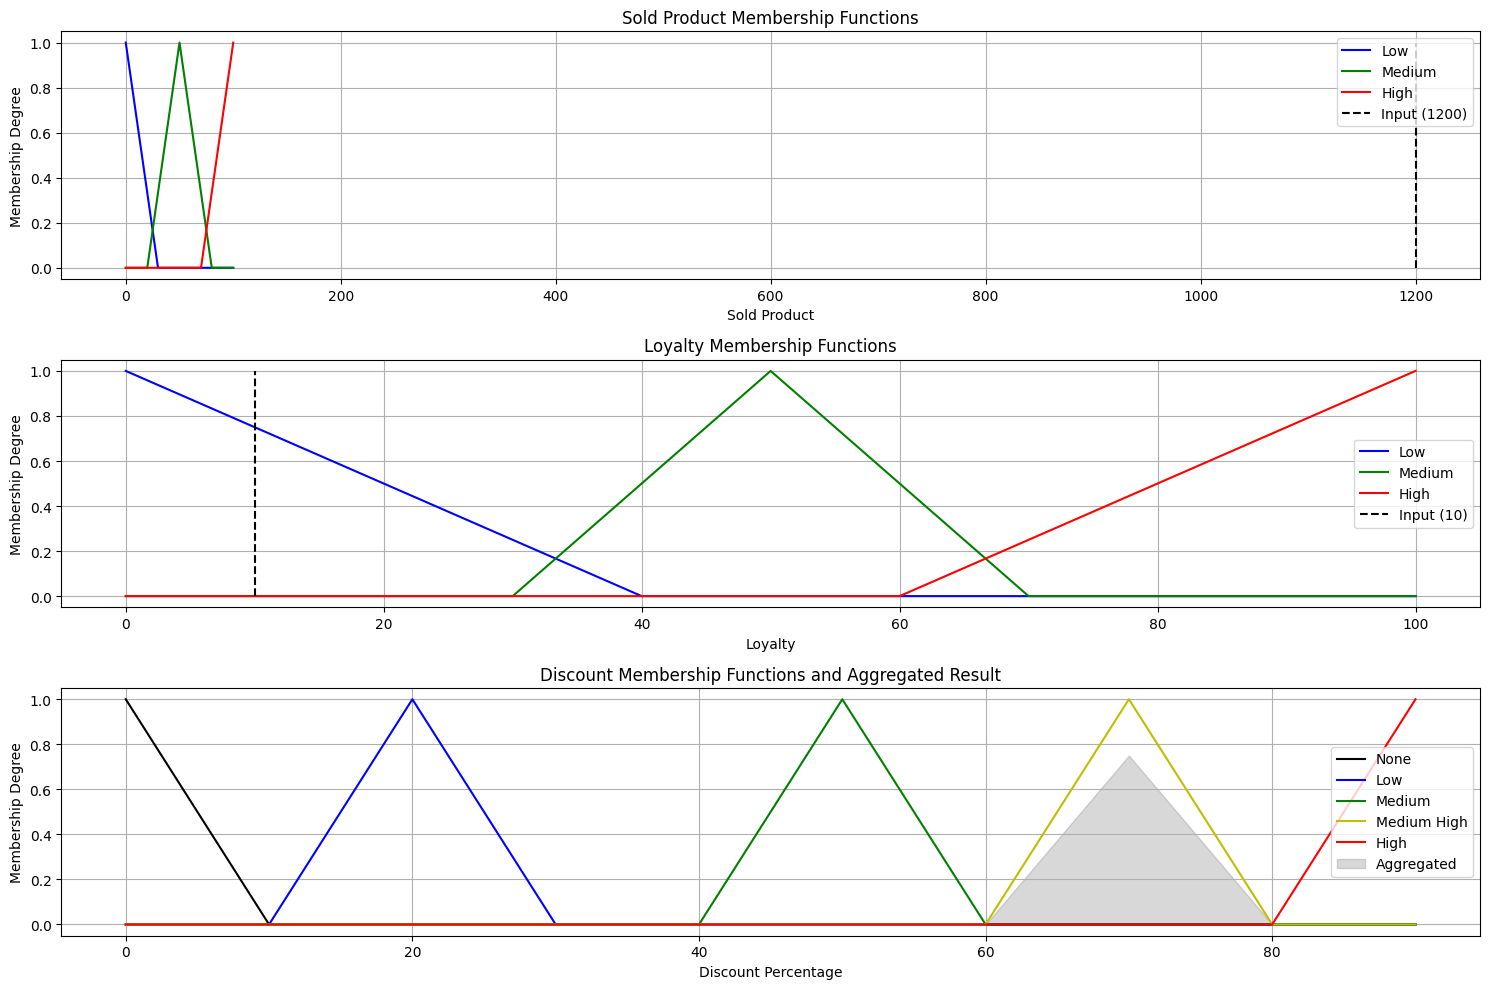

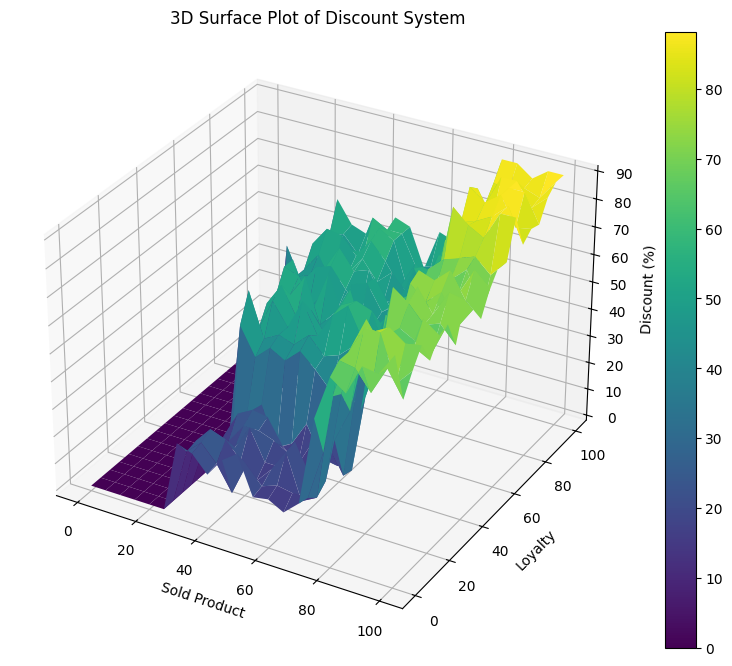

Diskon yang diberikan: 79%


In [57]:
discount = calculate_discount(1200, 10)
print(f"Diskon yang diberikan: {discount}%")